In [15]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')

if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [16]:
from __future__ import print_function

from collections import Counter

import hosts
import targeting
import mmthecto
import numpy as np

from astropy import units as u
from astropy.coordinates import *
from astropy import table
from astropy.table import Table
from astropy.io import fits

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (16, 10)

In [18]:
reload(hosts)

<module 'hosts' from 'hosts.py'>

In [19]:
hostlst = hosts.get_saga_hosts_from_google() #'named' hosts

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [20]:
hosts_to_target = [h for h in hostlst if h.name=='Sopranos']
assert len(hosts_to_target)==1

In [21]:
# now set to the latest base catalogs
for h in hosts_to_target:
    h.fnsdss = 'SAGADropbox/base_catalogs/base_sql_nsa{0}.fits.gz'.format(h.nsaid)
    h._cached_sdss = None

In [22]:
# actually make sure they're loaded here
for h in hosts_to_target:
    h.get_sdss_catalog()
h.get_sdss_catalog().colnames # just to see

['OBJID',
 'RA',
 'DEC',
 'PHOTPTYPE',
 'PHOT_SG',
 'FLAGS',
 'SATURATED',
 'BAD_COUNTS_ERROR',
 'BINNED1',
 'u',
 'g',
 'r',
 'i',
 'z',
 'u_err',
 'g_err',
 'r_err',
 'i_err',
 'z_err',
 'MODELMAGERR_U',
 'MODELMAGERR_G',
 'MODELMAGERR_R',
 'MODELMAGERR_I',
 'MODELMAGERR_Z',
 'EXTINCTION_U',
 'EXTINCTION_G',
 'EXTINCTION_R',
 'EXTINCTION_I',
 'EXTINCTION_Z',
 'DERED_U',
 'DERED_G',
 'DERED_R',
 'DERED_I',
 'DERED_Z',
 'PETRORAD_U',
 'PETRORAD_G',
 'PETRORAD_R',
 'PETRORAD_I',
 'PETRORAD_Z',
 'PETRORADERR_U',
 'PETRORADERR_G',
 'PETRORADERR_R',
 'PETRORADERR_I',
 'PETRORADERR_Z',
 'DEVRAD_U',
 'DEVRADERR_U',
 'DEVRAD_G',
 'DEVRADERR_G',
 'DEVRAD_R',
 'DEVRADERR_R',
 'DEVRAD_I',
 'DEVRADERR_I',
 'DEVRAD_Z',
 'DEVRADERR_Z',
 'DEVAB_U',
 'DEVAB_G',
 'DEVAB_R',
 'DEVAB_I',
 'DEVAB_Z',
 'CMODELMAG_U',
 'CMODELMAGERR_U',
 'CMODELMAG_G',
 'CMODELMAGERR_G',
 'CMODELMAG_R',
 'CMODELMAGERR_R',
 'CMODELMAG_I',
 'CMODELMAGERR_I',
 'CMODELMAG_Z',
 'CMODELMAGERR_Z',
 'PSFMAG_U',
 'PSFMAGERR_U',
 'P

Important difference from previous runs: ML probablities are now in the catalogs!

In [23]:
p_column_for_ranking = 'PROBABILITY_CLASS1' #this is *just* SDSS

In [46]:
# compute ranks, which includes filtering on mag
rankdct = {}
for h in hosts_to_target:
    cat = h.get_sdss_catalog()
    
    rankdct[h] = ranks = np.zeros(len(cat), dtype=int) #the 0s will be re-set at the end
    
    # now set the ml prob targets
    highprob = cat[p_column_for_ranking] > 0.5
    medprob = (cat[p_column_for_ranking] > 0.05) & ~highprob
    lowprob = (cat[p_column_for_ranking] > 0.01) & ~highprob & ~medprob
    inside = cat['RHOST_KPC']<300
    
    # rank 1 reserved for flux stars
    ranks[inside&highprob] = 2
    ranks[~inside&highprob] = 3
    ranks[inside&medprob] = 4
    ranks[~inside&medprob] = 5
    ranks[inside&lowprob] = 6
    ranks[~inside&lowprob] = 7
    
    validtarget = (cat['r'] < 21.5) & (cat['fibermag_r']<23) & (cat['phot_sg']=='GALAXY')
    other = ranks == 0
    colorcutmsk = targeting.colorcut_mask(cat,  targeting.bossanova_color_cuts)
    
    ranks[validtarget&other&colorcutmsk] = 8
    ranks[validtarget&other&~colorcutmsk] = 9
    
    #set to-remove objects to ranks<0
    tokeep = cat['REMOVE']==-1
    ranks[~tokeep] = -cat['REMOVE'][~tokeep] # sets the REMOVE objects to -their remove value
    # and the downloaded rem list
    remmsk = targeting.remove_targets_with_remlist(cat, h, maskonly=True)
    ranks[~remmsk] = -5
    # should also remove already-observed
    
    #informational
    print(h.name,'rank counts:', dict(Counter(ranks)))

Removed 15 objects for Sopranos
Sopranos rank counts: {0: 48604, 2: 20, 3: 11, 4: 12, 5: 9, 6: 16, 7: 22, 8: 12075, 9: 6079, -5: 16, -3: 4090, -2: 763}


### are the ML-selected objects meeting the fibermag and r cuts?

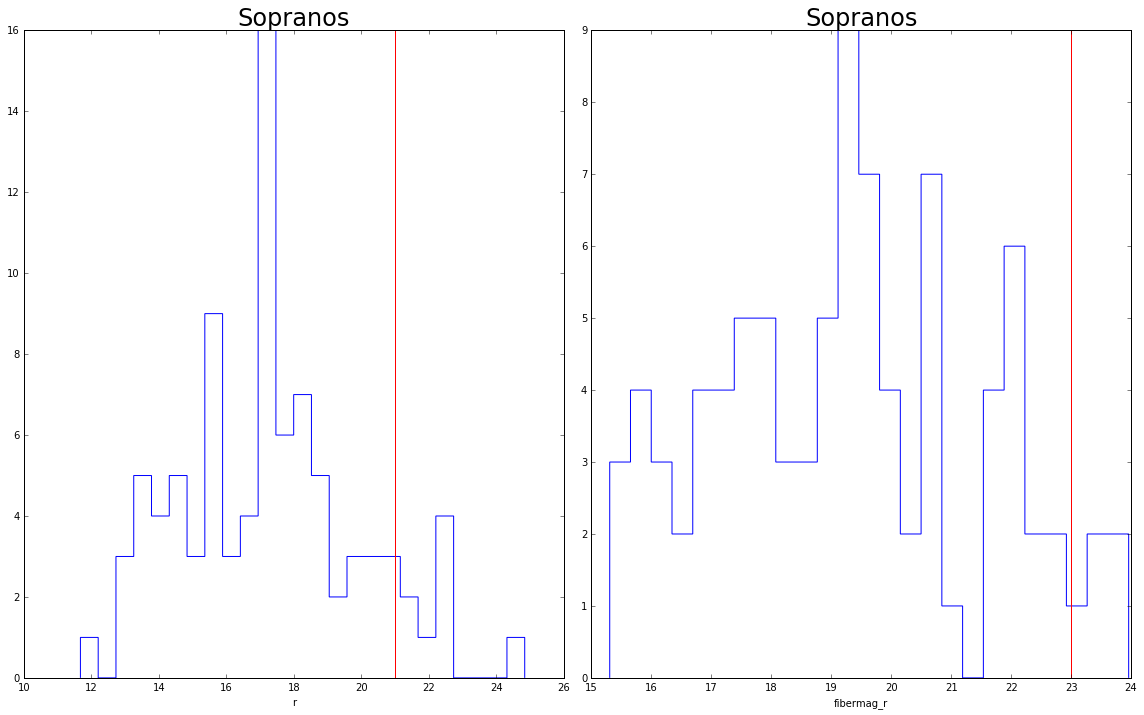

In [25]:
for h in hosts_to_target:
    cat = h.get_sdss_catalog()
    ranks = rankdct[h]

    plt.figure()
    
    msk = (ranks>0)&(ranks<8)
    plt.subplot(1,2,1)
    plt.hist(cat[msk]['r'],bins=25, histtype='step')
    plt.axvline(21,c='r')
    plt.xlabel('r')
    plt.title(h.name, fontsize=24)
    
    plt.subplot(1,2,2)
    plt.hist(cat[msk]['fibermag_r'],bins=25, histtype='step')
    plt.axvline(23,c='r')
    plt.xlabel('fibermag_r')
    plt.title(h.name, fontsize=24)
    
    plt.tight_layout()

# Generate catalogs 

In [26]:
generated_cats = {}
for h in hosts_to_target:
    print('On host', h.name)
    sys.stdout.flush()

    cat = h.get_sdss_catalog()
    ranks = rankdct[h]
    
    fnout = 'mmthecto/{0}_feb2016.cat'.format(h.name)
    fluxfnout = fnout.replace('.cat', '.fluxstars')
    print('Going to write', fnout)
    
    msk = (cat['RHOST_ARCM']<40) & (ranks>0) & (ranks<9)
    generated_cats[h] = mmthecto.generate_catalog(h, cat[msk], ranks[msk], 
                                         repeatflux=3, removefluxdistance=1*u.arcmin,
                                         fnout=fnout, fluxfnout=fluxfnout)

On host Sopranos
Going to write mmthecto/Sopranos_feb2016.cat
Including 5695 targets
Found 88 Flux stars
Removing 33 Flux stars too close to program stars
Could not find psf mags so falling back on regular mags...
Found 317 guide stars


### Inspect an output 

In [33]:
gcat = generated_cats[h]

msk = (ranknum>1)&(ranknum<6)
gcatm = gcat[msk]
targeting.sampled_imagelist(gcatm[np.argsort(gcatm['ra'])], None, None, names=gcat['rank'][msk])

ranknum = gcat['rank'].copy()
ranknum[gcat['rank']==''] = '-1'
ranknum = ranknum.astype(int)
{r: np.sum(r==ranknum) for r in set(ranknum)}

{-1: 317, 1: 165, 2: 20, 3: 1, 4: 12, 5: 2, 6: 16, 7: 3, 8: 5641}

In [34]:
#identify clumps of nearby objects
gcatmsc = SkyCoord(gcatm['ra'], gcatm['dec'], unit=u.deg)
seps = u.Quantity([c.separation(gcatmsc) for c in gcatmsc])

pairs = zip(*np.where((seps>0.1*u.arcsec)&(seps<10*u.arcsec)))
pairs = [pair for pair in pairs if pair[0]<pair[1]]

clumps = []
for p1, p2 in pairs:
    for clump in clumps:
        if p1 in clump:
            clump.append(p2)
            break
        elif p2 in clump:
            clump.append(p1)
            break
    else:
        clumps.append([p1, p2])
for cl in clumps:
    targeting.sampled_imagelist(gcatm[np.array(cl)], None, None, names=cl)
clumps

[]